# Temperature time series for some Brazilian cities

> The content is provided by NOAA GHCN v4 and post-processed by NASA's GISTEMP v4.
In summary, each data file contains a temperature time series for a station named according to the city. The time series provides temperature records by month for each year. Some mean measurement is calculated, like metANN and D-J-F. I can't give details about these quantities, nor how they are calculated. Please refer for NASA GISTEMP website in this regard. The most important seems to be metANN, which is an annual temperature mean.

Source: https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities

In [1]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 500)

In [2]:
df = pd.read_csv("../data/station_sao_paulo.csv")
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1946,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,999.90,21.74,999.90,999.90,999.90,999.90,999.90
1,1947,999.90,23.54,21.04,19.74,19.24,999.90,15.04,16.44,18.04,17.04,18.94,20.34,22.75,20.01,15.67,18.01,19.11
2,1948,23.64,22.94,20.74,20.04,18.04,16.64,17.84,15.64,18.64,18.74,20.64,21.24,22.31,19.61,16.71,19.34,19.49
3,1949,22.34,21.54,23.54,19.44,17.24,17.34,16.34,17.34,18.24,18.74,19.74,21.54,21.71,20.07,17.01,18.91,19.42
4,1950,22.14,22.44,22.24,20.44,19.44,17.94,16.44,19.14,19.54,19.04,19.94,21.94,22.04,20.71,17.84,19.51,20.02


In [3]:
df_melt = pd.melt(df, 
                  id_vars=['YEAR'], 
                  value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC',], 
                  var_name='month',
                  value_name='y')

df_melt["ds"] = pd.to_datetime(df_melt['YEAR'].astype(str) + '-' + df_melt['month'].astype(str) + '-01')

df_melt = df_melt.drop(columns=["YEAR", "month"])[["ds", "y"]]

df_melt = df_melt.sort_values(by="ds")

df_melt["y"] = df_melt["y"].replace(999.90, np.NaN)
df_melt["y"] = df_melt["y"].fillna(method='ffill')
df_melt = df_melt.dropna()
df_melt = df_melt.reset_index(drop=True)

df_melt.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,ds,y
0,1946-12-01,21.74
1,1947-01-01,21.74
2,1947-02-01,23.54
3,1947-03-01,21.04
4,1947-04-01,19.74


In [4]:
df_melt.describe(include="all")

,ds,y
count,877,877.000000
unique,877,NaN
top,1995-01-01 00:00:00,NaN
freq,1,NaN
first,1946-12-01 00:00:00,NaN
last,2019-12-01 00:00:00,NaN
mean,NaN,20.870319
std,NaN,2.502257
min,NaN,14.520000
25%,NaN,18.850000


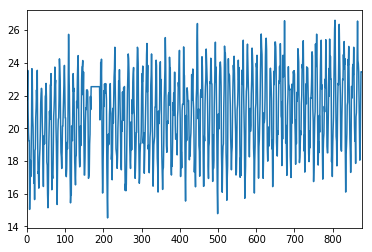

In [5]:
df_melt["y"].plot()

In [6]:
df_melt["ds"].describe()

count                     877
unique                    877
top       1995-01-01 00:00:00
freq                        1
first     1946-12-01 00:00:00
last      2019-12-01 00:00:00
Name: ds, dtype: object

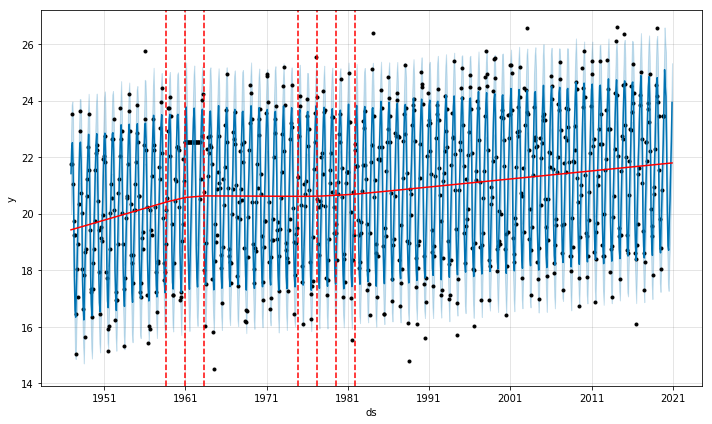

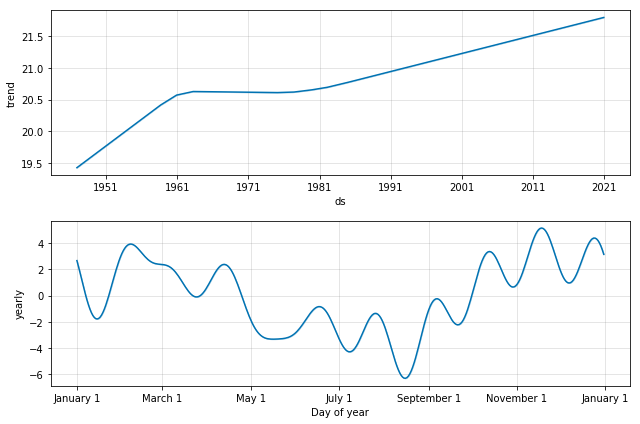

INFO:fbprophet:Making 22 forecasts with cutoffs between 1962-06-15 12:00:00 and 2014-12-02 00:00:00


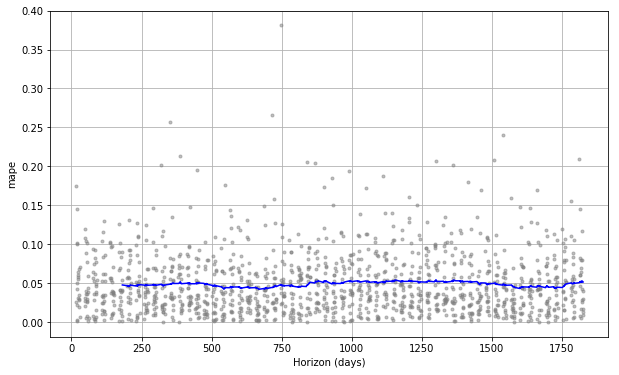

mape: 4.88%


In [59]:
m = Prophet(growth="linear",
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True,
            )
m.fit(df_melt)

future = m.make_future_dataframe(periods=12, freq='M')

forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()
fig2 = m.plot_components(forecast)
plt.show()
# df_cv = cross_validation(m, initial='21600 days', period='365 days', horizon = '4680 days')
df_cv = cross_validation(m, horizon = '1825 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [69]:
df_melt_logistic = df_melt.copy()
df_melt_logistic["floor"] = 12
df_melt_logistic["cap"] = 30

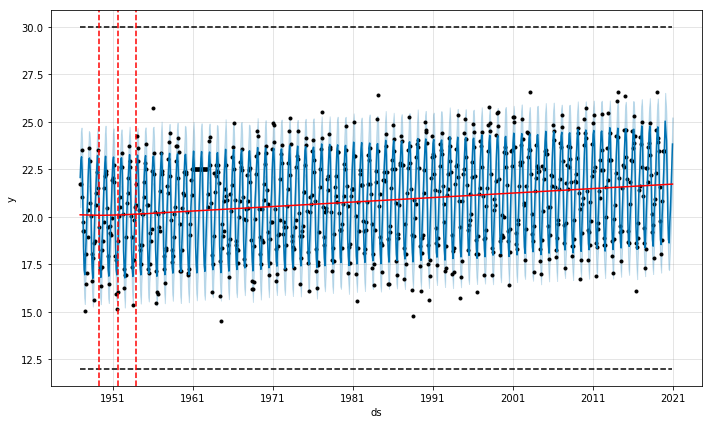

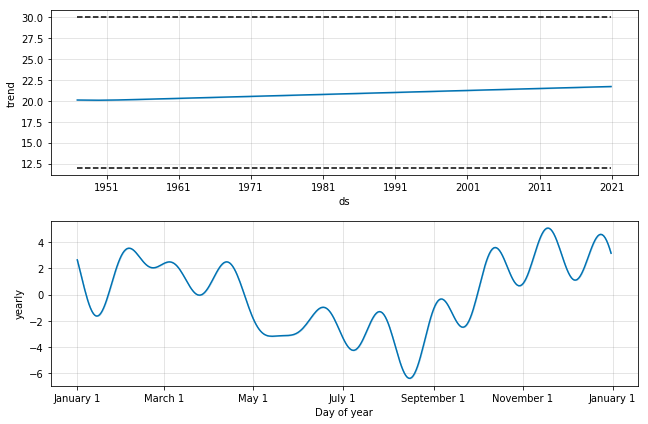

INFO:fbprophet:Making 7 forecasts with cutoffs between 1979-12-11 00:00:00 and 2009-12-03 00:00:00


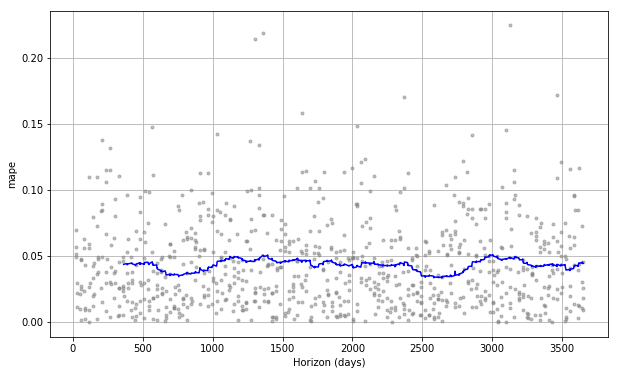

mape: 4.33%


In [70]:
m = Prophet(growth="logistic",
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True,
            )
m.fit(df_melt_logistic)

future = m.make_future_dataframe(periods=12, freq='M')
future["floor"] = 12
future["cap"] = 30

forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()
fig2 = m.plot_components(forecast)
plt.show()
# df_cv = cross_validation(m, initial='21600 days', period='365 days', horizon = '4680 days')
df_cv = cross_validation(m, horizon = '3650 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [8]:
df_melt.shape

(877, 2)